# Les méthodes ensemblistes ☕️☕️

## Introduction

Soit $\mathcal{X}$ notre espace d'entrée et $\mathcal{Y}$ notre espace de sortie. Soit $X, Y$ deux variables aléatoires sur $\mathcal{X}$ et $\mathcal{Y}$ et soit $\mathbb{P}$ leur mesure jointe. Notre objectif est de trouver une application $h:\mathcal{X}\mapsto\mathcal{Y}$ minimise une certaine erreur qu'on notera $L$. N'ayant pas accès aux variables aléatoires $X$ et $Y$, nous collectons un jeu de données $S_n=\{(X_i, Y_i)\}_{i\leq n}\sim\mathbb{P}^n$ et nous construisons un risque empirique :

$$L_n(h)=\frac{1}{n}\sum_{i}\ell(h(x_i), y_i),$$

où $\ell$ définit une erreur élémentaire (i.e. pour une unique prédiction). La fonction $h$ est ainsi construite en utilisant le jeu de données $S_n$.



## I. L'approche naïve

L'approche la plus simple lorsqu'on cherche à combiner plusieurs modèles consiste à moyenner leur prédiction. Dans le cas de la régression, la prédiction est la moyenne traditionnelle. Dans le cas de la classification, on utilisera un vote à la majorité simple.

In [83]:
from sklearn.datasets import load_digits
data = load_digits()

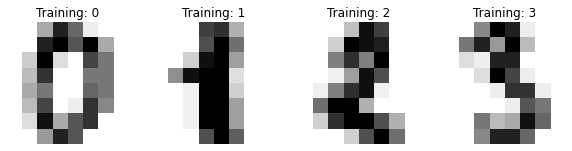

In [84]:
import matplotlib.pyplot as plt

_, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 3))
for ax, image, label in zip(axes, data.images, data.target):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title('Training: %i' % label)

In [3]:
from sklearn.model_selection import train_test_split
X = data.data / data.data.max()

X_train, X_test, y_train, y_test = train_test_split(X, data.target, test_size=0.75)

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
from scipy import stats

In [37]:
class MajorityVoting(object):
    def __init__(self, *models):
        self.models = models
    
    def fit(self, X, y):
        for m in self.models:
            m.fit(X, y)

    def predict(self, X):
        results = []
        for m in self.models:
            results.append(m.predict(X))
        results = np.array(results)
        return stats.mode(results).mode
    def score(self, X, y):
        scores = {'model': [], 'vote': None}
        for m in self.models:
            scores['model'].append(m.score(X, y))
        scores['vote'] = (self.predict(X) == y).astype(int).sum()/len(X)
        return scores
            
model = MajorityVoting(
    LogisticRegression(max_iter=5000), 
    DecisionTreeClassifier(),
    KNeighborsClassifier()
)
model.fit(X_train, y_train)

In [38]:
model.score(X_test, y_test)

{'model': [0.9495548961424333, 0.7826409495548962, 0.9703264094955489],
 'vote': 0.9577151335311572}

On peut imaginer que les modèles se trompent sur les mêmes images et non de manière aléatoire. C'est par exemple le cas si les modèles se trompent lorsqu'un chiffre est mal dessiné et ressemble à un autre chiffre : tous les modèles vont faire la même erreur. Ainsi, le meilleur modèle est le meilleur modèle et non le vote.

In [40]:
from sklearn.datasets import load_boston

data = load_boston()

In [48]:
from sklearn.model_selection import train_test_split
X = data.data/data.data.max(axis=0)
X_train, X_test, y_train, y_test = train_test_split(X, data.target, test_size=0.75)

In [70]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
import numpy as np
from scipy import stats

from sklearn.metrics import mean_squared_error

In [78]:
class AverageVoting(object):
    def __init__(self, *models):
        self.models = models
    
    def fit(self, X, y):
        for m in self.models:
            m.fit(X, y)

    def predict(self, X):
        results = []
        for m in self.models:
            results.append(m.predict(X))
        results = np.array(results)
        return results.mean(axis=0)
    
    def score(self, X, y):
        scores = {'model': [], 'vote': None}
        for m in self.models:
            scores['model'].append(mean_squared_error(y, m.predict(X)))
        scores['vote'] = mean_squared_error(y, self.predict(X))
        return scores
            
model = AverageVoting(
    LinearRegression(), 
    DecisionTreeRegressor(),
    KNeighborsRegressor()
)
model.fit(X_train, y_train)

In [79]:
model.score(X_test, y_test)

{'model': [21.243993021269304, 22.261184210526316, 34.079805263157894],
 'vote': 16.646423166483324}

On observe cette fois-ci un gain clair des performances. Les différents modèles doivent se tromper de manière aléatoire répartie autour de la moyenne. L'agrégation rend ce résultat plus stable.

## II. Bayesian Model Averaging (et son lien avec la régularisation)

Notons $z_i=(x_i, y_i)$ et une famille de $M$ modèles probabilistes (e.g. régression logistique) où chaque modèle est noté $\mathcal{M}_j$. Notons :

$$p(y_i|x_i, \mathcal{M}_j),$$

la densité d'un point de $\mathcal{Y}$ relativement au modèle $\mathcal{M}_j$ et à une observation $x_i\in\mathcal{X}$. Notre objectif est de déterminer dans un premier temps la "qualité" d'un modèle en tenant compte de notre point de vu *a priori* ainsi que des données que nous avons pu observer $S_n$. Notons ainsi $p(\mathcal{M}_j)$ notre probabilité *a priori* sur le modèle $\mathcal{M}_j$. Celle-ci peut favoriser certaines solutions parcimonieuses ou bien être uniforme et ne favoriser aucun modèle. En appliquant la règle de Bayes, nous obtenons :

$$p(\mathcal{M}_j|S_n)=\frac{p(S_n|\mathcal{M}_j)p(\mathcal{M}_j)}{p(S_n)},$$

où nous avons :

$$p(S_n|\mathcal{M}_j)=\prod_i p(y_i|x_i, \mathcal{M}_j),$$

ainsi que :

$$p(S_n)=\sum_j p(S_n| \mathcal{M}_j)p(\mathcal{M}_j).$$

Nous avons bien ici toutes les informations nous permettant d'évaluer de manière Bayésienne la qualité de nos différents modèles. Cependant, en pratique, les variations pourraient très bien dépendre d'un tirage particulier de nos données. L'idée derrière le *Bayesian Model Averaging* consiste à considérer TOUS les modèles mais à les pondérer par leur qualité. Cela ne se fait pas au doigt mouillé, mais en utilisant encore une fois le *framework* probabiliste :

$$p(y|x_\text{new}, S_n)=\sum_j p(y|x_\text{new}, \mathcal{M}_j, S_n)p(\mathcal{M}_j|S_n)$$

Dans le cas de la régression logistique, nous avons la vraisemblance suivante :

$$\mathcal{L}(\theta_j)=\prod_i p(y_i|x_i,\theta_j)$$

où

$$p(y_i|x_i, \theta_j)=\sigma_j(x_i)^y_i(1-\sigma_j(x_i))^{1-y_i}$$

et

$$\sigma_j(x)=(1+e^{-\langle\theta_j,x\rangle})^{-1}.$$

Ainsi, la *posterior* de notre modèle $\theta_j$ après avoir observé notre jeu de données est donnée par :

$$p(\theta_j|S_n)\propto \prod_i p(y_i|x_i,\theta_j)p(\theta_j).$$

In [268]:
# TODO exercice où des modèles logistiques prennent en compte que des paramètres choisis aléatoirement

In [269]:
from sklearn.datasets import load_digits
data = load_digits()

On affiche les pixels que verront par exemple un modèle.

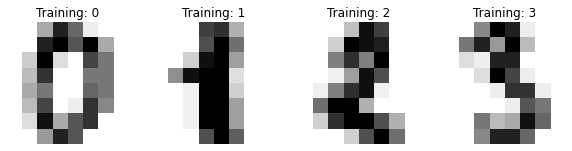

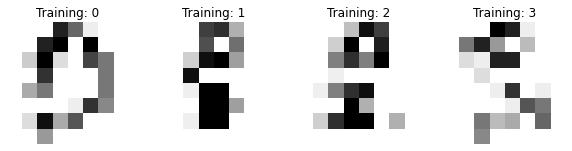

In [92]:
import matplotlib.pyplot as plt

_, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 3))
for ax, image, label in zip(axes, data.images, data.target):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title('Training: %i' % label)

mask = np.random.binomial(n=1, p=0.3, size=data.images[0].shape).astype(bool)

_, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 3))
for ax, image, label in zip(axes, data.images, data.target):
    ax.set_axis_off()
    ax.imshow(
        np.ma.masked_array(image, mask=mask), 
        cmap=plt.cm.gray_r, 
        interpolation='nearest'
    )
    ax.set_title('Training: %i' % label)

In [271]:
from sklearn.model_selection import train_test_split
X = data.data / data.data.max()

X_train, X_test, y_train, y_test = train_test_split(X, data.target, test_size=0.75)

In [272]:
from sklearn.linear_model import LogisticRegression
import numpy as np
from scipy.special import logsumexp

In [273]:
class BayesianLogisticAveraging(object):
    def __init__(self, dim=64, p=0.5, nb_models=50, max_iter=5000):
        self.mask = np.random.binomial(n=1, p=p, size=(nb_models, dim)).astype(bool)
        self.nb_models = nb_models
        self.models = []
        self.posterior = []
        self.prior = 1./nb_models
        self.max_iter = max_iter
        
    def posterior_(self, i, X, y):
        p = self.models[i].predict_proba(X)

        return np.log(p[np.arange(len(p)), y]).sum() + np.log(self.prior)
        
        
    def fit(self, X_train, y_train):
        for _ in range(self.nb_models):
            model = LogisticRegression(max_iter=self.max_iter)
            X = X_train[:, self.mask[_]]
            model.fit(X, y_train)
            self.models.append(model)
            self.posterior.append(
                self.posterior_(_, X, y_train)
            )
    def individual_scores(self, X, y):
        scores = []
        for _ in range(len(self.models)):
            scores.append(self.models[_].score(X[:, self.mask[_]], y))
        print(np.max(scores))
            
    def predict(self, X):
        predictions = []
        for i, model in enumerate(self.models):
            predictions.append(
                np.log(model.predict_proba(X[:, self.mask[i]]))+self.posterior[i]
            )
        predictions = np.array(predictions)
        return logsumexp(predictions, axis=0).argmax(axis=1)
        
    def score(self, X, y):
        pred = self.predict(X)
        acc = (pred==y).astype(int).sum()/len(X)
        return acc

model = BayesianLogisticAveraging()
model.fit(X_train, y_train)
model.individual_scores(X_test, y_test)
model.predict(X_test)
# print(np.argsort(model.posterior))
#print(model.posterior)
model.score(X_test, y_test)

0.9295252225519288


0.9295252225519288

In [276]:
class LogisticMaxPooling(object):
    def __init__(self, dim=64, p=0.5, nb_models=50, max_iter=5000):
        self.mask = np.random.binomial(n=1, p=p, size=(nb_models, dim)).astype(bool)
        self.nb_models = nb_models
        self.models = []
        self.max_iter = max_iter
        
        
    def fit(self, X_train, y_train):
        for _ in range(self.nb_models):
            model = LogisticRegression(max_iter=self.max_iter)
            X = X_train[:, self.mask[_]]
            model.fit(X, y_train)
            self.models.append(model)
            
    def individual_scores(self, X, y):
        scores = []
        for _ in range(len(self.models)):
            scores.append(self.models[_].score(X[:, self.mask[_]], y))
        print('Best model:', np.max(scores), ':: Worst model:', np.min(scores))
            
    def predict(self, X):
        predictions = []
        for i, model in enumerate(self.models):
            predictions.append(
                model.predict_proba(X[:, self.mask[i]])
            )
        predictions = np.array(predictions)
        return predictions.max(axis=0).argmax(axis=1)
        
    def score(self, X, y):
        pred = self.predict(X)
        acc = (pred==y).astype(int).sum()/len(X)
        return acc

model = LogisticMaxPooling()
model.fit(X_train, y_train)
model.individual_scores(X_test, y_test)
model.predict(X_test)
# print(np.argsort(model.posterior))
#print(model.posterior)
model.score(X_test, y_test)

Best model: 0.9399109792284867 :: Worst model: 0.7856083086053413


0.9280415430267063

Le principe du *Bayesian Model Averaging* se généralise bien sûr lorsqu'on a une quantité infinie de modèles où la *posterior* prédictive s'écrit :

$$p(y|x_\text{new}, S_n)=\int p(y|x_\text{new}, \mathcal{M}, S_n)p(\mathcal{M}|S_n)dM.$$

---
### La régression linéaire Bayésienne

**Le modèle**

Considérons le modèle linéaire suivant. Soit $X\in\mathbb{R}^d$, $\omega\in\mathbb{R}^d$, $\epsilon\sim\mathcal{N}(0, \sigma^2)$ et considérons la dépendence suivante :

$$Y=\langle \omega, X\rangle + \epsilon.$$

On supposera dans cet exercice que les matrices qu'on inverse sont inversibles.

Nous avons donc $Y\sim\mathcal{N}(\langle\omega, X\rangle, \sigma^2)$. Ici, chaque paramétrisation (chaque choix de $\omega$) peut être vu comme un modèle. Comme pour le cas précédent, nous devons donner une mesure *a priori* pour chacun de nos modèles. Nous choissons ici le *prior* suivant :

$$p(\omega)=\mathcal{N}(0, \sigma^2\Lambda^{-1}),$$

où $\Lambda$ est la matrice de précision. Par facilité, considérons $\Lambda=\lambda I$ et notons $\Sigma=\sigma^2\Lambda^{-1}$.  

**Détail des calculs pour la régression linéaire Bayésienne (ou Bayesian Model Averaging with Linear Regression**

(Si vous n'êtes intéressés que par la solution, vous pouvez sauter directement les calculs)

***Étape 1 : Calcul de la posterior sur $\omega$***

Nous cherchons dans un premier temps à calculer :

$$p(y|\tilde{X}, \omega)\propto\text{exp}\Big(-\frac{1}{2\sigma^2}(y-\tilde{X}\omega )^T(y-\tilde{X}\omega)\Big)$$

où

$$\tilde{X}=\begin{pmatrix}x_1^T\\\vdots\\x_n^T\end{pmatrix}\text{ et }y=\begin{pmatrix}y_1\\\vdots\\y_n\end{pmatrix}.$$

C'est notre likelihood. Si en maximisant cette quantité qu'on obtient (lorsque $\tilde{X}^T\tilde{X}$ est inversible) :

$$\hat{\omega}=(\tilde{X}^T\tilde{X})^{-1}\tilde{X}^ty$$

On rappelle notre prior sur $\omega$ :

$$p(\omega)\propto\text{exp}\Big(-\frac{1}{2}\omega^T\Sigma^{-1}\omega\Big)=\text{exp}\Big(-\frac{\lambda}{2\sigma^2}\omega^T\omega\Big).$$

Nous avons donc tous les éléments nous permettant de calculer notre *posterior* :

$$p(\omega|\tilde{X}, y)\propto p(y|\tilde{X},\omega)p(\omega).$$

En remplaçant les quantités ci-dessus, nous obtenons donc :

$$p(\omega|\tilde{X}, y)\propto \text{exp}\Big(-\frac{1}{2\sigma^2}(y-\tilde{X}\omega )^T(y-\tilde{X}\omega)-\frac{\lambda}{2\sigma^2}\omega^T\omega\Big).$$

Notre prior sur $\omega$ est conjugué avec notre vraisemblance. Cela veut dire que la *posterior* est donc nécessairement une loi normale également. Ainsi, on sait qu'elle sera proportionnelle à l'exponentielle de :

$$(\omega-\mu)^T{\Sigma^\prime}^{-1}(\omega-\mu)=\omega^T{\Sigma^\prime}^{-1}\omega-2\omega^T{\Sigma^\prime}^{-1}\mu+\text{constante}.$$

où $\mu$ sera le paramètre de moyenne et $\Sigma^\prime$ notre nouvelle matrice de covariance. Considérons donc la quantité $\frac{1}{\sigma^2}(y-\tilde{X}\omega )^T(y-\tilde{X}\omega)+\frac{\lambda}{\sigma^2}\omega^T\omega$ (nous avons factorisé par $-1/2$ les éléments de l'exponentiel) et cherchons à obtenir la forme classique attendue d'une loi normale :

$$\begin{aligned}
\frac{1}{\sigma^2}(y-\tilde{X}\omega )^T(y-\tilde{X}\omega)+\frac{\lambda}{\sigma^2}\omega^T\omega&=\sigma^{-2}(y^Ty-2\omega^T\tilde{X}^T y+\omega^T\tilde{X}^T\tilde{X}\omega)+\lambda\sigma^{-2}\omega^T\omega\\
&=\sigma^{-2}y^Ty-2\sigma^{-2}\omega^T\tilde{X}^Ty+\sigma^{-2}\omega^T(\tilde{X}^T\tilde{X}+\lambda I)\omega
\end{aligned}$$

On remarque ainsi directement que :

$$\begin{aligned}
{\Sigma^\prime}^{-1}&=\frac{\tilde{X}^T\tilde{X}+\lambda I}{\sigma^2}
\end{aligned}$$

Et on en déduit que :

$$\mu=(\tilde{X}^T\tilde{X}+\lambda I)^{-1}\tilde{X}^T y.$$

On remarque que l'espérance de notre posterior est exactement l'estimateur de Ridge. Dans notre cas de figure, la posterior est une loi normale et est ainsi symétrique : son maximum est atteint par son espérance. On parle souvent de MAP, ou Maximum A Posteriori.

***Étape 2 : Calcul de la posterior prédictive sur $y_\text{new}$***

Maintenant que nous avons la posterior pour nos modèles, nous pouvons calculer la *posterior* prédictive. Celle-ci s'exprime de la manière suivante :

$$\begin{aligned}
p(y_{\text{new}}| x_{\text{new}}, \tilde{X}, y)&=\int_\omega p(y_{\text{new}}|x_{\text{new}}, \omega)p(\omega|\tilde{X}, y)d\omega\text{ (la dépendance en $X$ disparait)}\\
&\propto\int_\omega\text{exp}\Big(-\frac{1}{2\sigma^2}(y_{\text{new}}-\langle \omega, x_{\text{new}}\rangle)^2\Big)\text{exp}\Big(-\frac{1}{2}(\omega-\mu)^T{\Sigma^\prime}^{-1}(\omega-\mu)\Big)d\omega\\
&=\int_\omega\text{exp}\Big(-\frac{1}{2}\big(\sigma^{-2}(y_{\text{new}}^2-2y_{\text{new}}\langle \omega, x_{\text{new}}\rangle+(\langle \omega, x_{\text{new}}\rangle)^2+\omega^T{\Sigma^\prime}^{-1}\omega-2\omega^T{\Sigma^\prime}^{-1}\mu+\\&\mu^T{\Sigma^\prime}^{-1}\mu\big)\Big)d\omega
\end{aligned}$$

où $\mu^T{\Sigma^\prime}^{-1}\mu$ n'agit que comme un facteur de proportionnalité et peut donc être "éliminé".

***Étape 2.1 : Intégration de la variable $\omega$***

Nous allons dans un premier temps regrouper tous les éléments faisant intervenir $\omega$, notre variable d'intégration.


$$\begin{aligned}
p(y_{\text{new}}| x_{\text{new}}, \tilde{X}, y)&\propto\int_\omega\text{exp}\Big(-\frac{1}{2}\big(\sigma^{-2}(y_{\text{new}}^2-2y_{\text{new}}\langle \omega, x_{\text{new}}\rangle+(\langle \omega, x_{\text{new}}\rangle)^2+\omega^T{\Sigma^\prime}^{-1}\omega-2\omega^T{\Sigma^\prime}^{-1}\mu\big)\Big)d\omega
\end{aligned}$$


Considérons à nouveau la partie entre parenthèses :

$$\begin{aligned}
\sigma^{-2}(y_{\text{new}}^2-2y_{\text{new}}&\langle \omega, x_{\text{new}}\rangle+(\langle \omega, x_{\text{new}}\rangle)^2+\omega^T{\Sigma^\prime}^{-1}\omega-2\omega^T{\Sigma^\prime}^{-1}\mu\\
&=y_\text{new}^2\sigma^{-2}-2\omega^T({\Sigma^\prime}^{-1}\mu+x_\text{new}y_\text{new}\sigma^{-2})+\omega^T(x_\text{new}x_\text{new}^T\sigma^{-2}+{\Sigma^\prime}^{-1})\omega\\
&=(\omega-\mu^\prime){\Sigma^{\prime\prime}}^{-1}(\omega-\mu^\prime)-{\mu^\prime}^T{\Sigma^{\prime\prime}}^{-1}\mu^\prime+y_{\text{new}}^2\sigma^{-2}
\end{aligned}$$


où :

$${\Sigma^{\prime\prime}}^{-1}=x_\text{new}x_\text{new}^T\sigma^{-2}+{\Sigma^\prime}^{-1},$$

et :

$$\mu^\prime={\Sigma^{\prime\prime}}({\Sigma^\prime}^{-1}\mu+x_{\text{new}}y_\text{new}\sigma^{-2}).$$

On en déduit ainsi :

$$\begin{aligned}
p(y_{\text{new}}| x_{\text{new}}, \tilde{X}, y)&\propto\text{exp}\Big(\frac{1}{2}{\mu^\prime}^T{\Sigma^{\prime\prime}}^{-1}\mu^\prime-\frac{1}{2}y_{\text{new}}^2\sigma^{-2}\Big)\int_\omega \text{exp}\Big(-\frac{1}{2}(\omega-\mu^\prime){\Sigma^{\prime\prime}}^{-1}(\omega-\mu^\prime)\Big)d\omega\\
&\propto\text{exp}\Big(\frac{1}{2}{\mu^\prime}^T{\Sigma^{\prime\prime}}^{-1}\mu^\prime-\frac{1}{2}y_{\text{new}}^2\sigma^{-2}\Big),
\end{aligned}$$

où nous avons pu sortir les éléments constants relativement à $\omega$ de l'intégral. N'y trouvant plus qu'une loi normale dont la probabilité vaut $1$ sur son domaine, nous avons pu éliminer l'intégrale (toujours à un facteur proportionnel près).

***Étape 2.2 : Calcul de la loi de $y_\text{new}$***

On sent que la loi de $y_\text{new}$ sera aussi une loi normale, et on va essayer de retrouver quelque chose qui ressemble à :
On sait qu'on aura quelque chose de la forme :

$$\begin{aligned}
p(y_\text{new}|x_\text{new}, \tilde{X}, y)&\propto\text{exp}\Big(-\frac{1}{2{\sigma^\prime}^2}(y_\text{new}-\mu^{\prime\prime)^2}\Big)\\
&=\text{exp}\Big(-\frac{1}{2}({\sigma^\prime}^{-2}y_\text{new}^2-2{\sigma^\prime}^{-2}y_\text{new}\mu^{\prime\prime}+{\sigma^\prime}^{-2}{\mu^{\prime\prime}}^2)\Big),
\end{aligned}
$$

où $\mu^{\prime\prime}$ sera l'espérance de notre prédiction et $\sigma^\prime$ son écart-type. Rappelons que notre point de départ ici est : 

$$\text{exp}\Big(\frac{1}{2}{\mu^\prime}^T{\Sigma^{\prime\prime}}^{-1}\mu^\prime-\frac{1}{2}y_{\text{new}}^2\sigma^{-2}\Big).$$

En constatant que $\Sigma, \Sigma^\prime$ ou encore $\Sigma^{\prime\prime}$ sont toutes symétriques, nous avons :

$$\begin{aligned}
{\mu^\prime}^T{\Sigma^{\prime\prime}}^{-1}\mu^\prime&=({\Sigma^\prime}^{-1}\mu+x_{\text{new}}y_\text{new}\sigma^{-2})^T{\Sigma^{\prime\prime}}{\Sigma^{\prime\prime}}^{-1}{\Sigma^{\prime\prime}}({\Sigma^\prime}^{-1}\mu+x_{\text{new}}y_\text{new}\sigma^{-2})\\
&=\sigma^{-2}y_\text{new}x_\text{new}^T\Sigma^{\prime\prime}\sigma^{-2}y_\text{new}x_\text{new}+2y_\text{new}\sigma^{-2}x_\text{new}^T\Sigma^{\prime\prime}{\Sigma^\prime}^{-1}\mu+\text{constante}\\
&=(\sigma^{-4}x_\text{new}^T\Sigma^{\prime\prime}x_\text{new})y_\text{new}^2+2(\sigma^{-2}x_\text{new}^T\Sigma^{\prime\prime}{\Sigma^\prime}^{-1}\mu) y_\text{new}+\text{constante}.
\end{aligned}$$

En combinant ${\mu^\prime}^T{\Sigma^{\prime\prime}}^{-1}\mu^\prime$ avec $-y_{\text{new}}^2\sigma^{-2}$, nous obtenons :

$$\begin{aligned}
{\mu^\prime}^T{\Sigma^{\prime\prime}}^{-1}\mu^\prime-y_{\text{new}}^2\sigma^{-2}&=(\sigma^{-4}x_\text{new}^T\Sigma^{\prime\prime}x_\text{new}-\sigma^{-2})y_\text{new}^2+2(\sigma^{-2}x_\text{new}^T\Sigma^{\prime\prime}{\Sigma^\prime}^{-1}\mu) y_\text{new}+\text{c}
\end{aligned}$$

Remarquons que dans l'exponentielle nous n'avons pas indiqué le signe "-" classique de la loi normale. Nous obtenons ainsi :

$$\begin{aligned}
y_{\text{new}}^2\sigma^{-2}-{\mu^\prime}^T{\Sigma^{\prime\prime}}^{-1}\mu^\prime&=(\sigma^{-2}-\sigma^{-4}x_\text{new}\Sigma^{\prime\prime}x_\text{new})y_\text{new}^2-2(\sigma^{-2}x_\text{new}\Sigma^{\prime\prime}{\Sigma^\prime}^{-1}\mu)y_\text{new}+c
\end{aligned}$$

On retrouve donc :

$$\begin{aligned}
{\sigma^\prime}^{-2}=\sigma^{-2}(1-\sigma^{-2}x_\text{new}^T\Sigma^{\prime\prime}x_\text{new})\\
\mu^{\prime\prime}={\sigma^\prime}^2\sigma^{-2}x_\text{new}^T\Sigma^{\prime\prime}{\Sigma^\prime}^{-1}\mu.
\end{aligned}$$

Nous avons :

$$\begin{aligned}
p(y_\text{new}|x_\text{new}, \tilde{X}, y)&\propto\text{exp}\Big(-\frac{{\sigma^\prime}^{-2}}{2}(y_\text{new}-\mu^{\prime\prime)^2}\Big)
\end{aligned}$$



***Étape 2.3 : Un peu de nettoyage***

Nous avons grâce à la formule de [Sherman–Morrison](https://en.wikipedia.org/wiki/Sherman–Morrison_formula) :

$$\Sigma^{\prime\prime}=(x_\text{new}x_\text{new}^T\sigma^{-2}+{\Sigma^\prime}^{-1})^{-1}={\Sigma^\prime}-\frac{{\Sigma^\prime}\sigma^{-2}x_\text{new}x_\text{new}^T{\Sigma^\prime}}{1+\sigma^{-2}x_\text{new}^T{\Sigma^\prime}x_\text{new}}$$

Nous avons donc :

$$x_\text{new}^T\Sigma^{\prime\prime}x_{\text{new}}=x_\text{new}^T\Sigma^\prime x_\text{new}-\frac{\sigma^{-2}(x_\text{new}^T\Sigma^\prime x_\text{new})^2}{1+\sigma^{-2}x_\text{new}^T{\Sigma^\prime}x_\text{new}}=\frac{x_\text{new}^T\Sigma^\prime x_\text{new}}{1+\sigma^{-2}x_\text{new}^T\Sigma^\prime x_\text{new}}.$$

Reprenons $\sigma^\prime$. Nous avons enfin :

$${\sigma^\prime}^{-2}=\sigma^{-2}(1-\sigma^{-2}\frac{x_\text{new}^T\Sigma^\prime x_\text{new}}{1+\sigma^{-2}x_\text{new}^T\Sigma^\prime x_\text{new}})=\frac{\sigma^{-2}}{1+\sigma^{-2}x_\text{new}^T\Sigma^\prime x_\text{new}}$$

Considérons maintenant $\mu^{\prime\prime}$ :

$$\mu^{\prime\prime}={\sigma^\prime}^2\sigma^{-2}x_\text{new}^T\Sigma^{\prime\prime}{\Sigma^\prime}^{-1}\mu=\mu^T{\sigma^\prime}^2\sigma^{-2}\Sigma^{\prime\prime}{\Sigma^\prime}^{-1}x_\text{new}.$$

Traitons la partie à droite et montrons :

$$\begin{aligned}
{\sigma^\prime}^2\sigma^{-2}\Sigma^{\prime\prime}{\Sigma^\prime}^{-1}x_\text{new}&=x_\text{new}\\
\Leftrightarrow {\sigma^\prime}^2\sigma^{-2} x_\text{new}&={\Sigma^{\prime\prime}}^{-1}\Sigma^\prime x_\text{new}\\&
=(x_\text{new}x_\text{new}^T\sigma^{-2}+{\Sigma^\prime}^{-1})\Sigma^\prime x_\text{new}\\
&=\sigma^{-2}x_\text{new}x_\text{new}^T\Sigma^\prime x_\text{new}+x_\text{new}\\
&= (\sigma^{-2}x_\text{new}^T\Sigma^\prime x_\text{new} + 1)x_\text{new}\\
\Leftrightarrow {\sigma^\prime}^2x_\text{new}&=\frac{\sigma^{-2}x_\text{new}^T\Sigma^\prime x_\text{new} + 1}{\sigma^{-2}}x_\text{new}\\
\Leftrightarrow x_\text{new}&=x_\text{new}.
\end{aligned}$$

Et nous obtenons ce que nous voulions montrer. Cela nous indique que nous avons : 

$$\mu^{\prime\prime}=\mu^T x_\text{new},$$

où 

$$\mu=(\tilde{X}^T\tilde{X}+\lambda I)^{-1}\tilde{X}^T y.$$

**Conclusion**

Nous obtenons donc, étant donné une observation $x_\text{new}$ que son label $y_\text{new}$ est distribué selon une loi normale dont la moyenne est :

$$\mu^T x_\text{new}$$

avec :

$$\mu=(\tilde{X}^T\tilde{X}+\lambda I)^{-1}\tilde{X}^T y,$$

et dont la variance est donnée par :

$${\sigma^\prime}^{-2}=\frac{\sigma^{-2}}{1+\sigma^{-2}x_\text{new}^T\Sigma^\prime x_\text{new}}$$

où 

$${\Sigma^\prime}^{-1}=\frac{\tilde{X}^T\tilde{X}+\lambda I}{\sigma^2}.$$

Cela nous dit finalement qu'une prédiction d'un modèlre Ridge revient à prendre l'espérance d'un Bayesian Model Averaging où nos modèles sont les modèles linéaires auquel on ajoute comme *prior* une loi normale dont la variance est contrôlée par le paramètre $1/\lambda$.

On retrouve ce modèle dans $\texttt{sklearn}$ avec $\texttt{BayesianRidge}$.

---

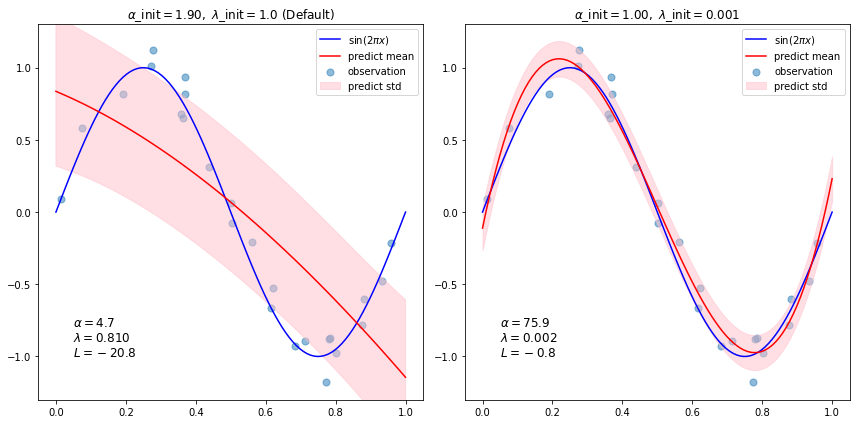

In [4]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import BayesianRidge


def func(x): return np.sin(2*np.pi*x)


# #############################################################################
# Generate sinusoidal data with noise
size = 25
rng = np.random.RandomState(1234)
x_train = rng.uniform(0., 1., size)
y_train = func(x_train) + rng.normal(scale=0.1, size=size)
x_test = np.linspace(0., 1., 100)


# #############################################################################
# Fit by cubic polynomial
n_order = 3
X_train = np.vander(x_train, n_order + 1, increasing=True)
X_test = np.vander(x_test, n_order + 1, increasing=True)

# #############################################################################
# Plot the true and predicted curves with log marginal likelihood (L)
reg = BayesianRidge(tol=1e-6, fit_intercept=False, compute_score=True)
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
for i, ax in enumerate(axes):
    # Bayesian ridge regression with different initial value pairs
    if i == 0:
        init = [1 / np.var(y_train), 1.]  # Default values
    elif i == 1:
        init = [1., 1e-3]
        reg.set_params(alpha_init=init[0], lambda_init=init[1])
    reg.fit(X_train, y_train)
    ymean, ystd = reg.predict(X_test, return_std=True)

    ax.plot(x_test, func(x_test), color="blue", label="sin($2\\pi x$)")
    ax.scatter(x_train, y_train, s=50, alpha=0.5, label="observation")
    ax.plot(x_test, ymean, color="red", label="predict mean")
    ax.fill_between(x_test, ymean-ystd, ymean+ystd,
                    color="pink", alpha=0.5, label="predict std")
    ax.set_ylim(-1.3, 1.3)
    ax.legend()
    title = "$\\alpha$_init$={:.2f},\\ \\lambda$_init$={}$".format(
            init[0], init[1])
    if i == 0:
        title += " (Default)"
    ax.set_title(title, fontsize=12)
    text = "$\\alpha={:.1f}$\n$\\lambda={:.3f}$\n$L={:.1f}$".format(
           reg.alpha_, reg.lambda_, reg.scores_[-1])
    ax.text(0.05, -1.0, text, fontsize=12)

plt.tight_layout()
plt.show()

## III. Boosting

L'idée primaire derrière la méthode de *boosting* est de construire des modèles "faibles" (potentiellement à peine meilleurs que le hasard) mais complémentaires entre eux possédant ainsi de bonnes performances en tant que groupe. Nous étudierons ici la méthode *AdaBoost* (i.e. Adaptive Boosting). Soit $\mathcal{X}\subseteq\mathbb{R}^d$ et $\mathcal{Y}=\{-1, 1\}$. On ne considèrera que le cas de la classification binaire bien que le propos se généralise à d'autres tâches de *machine learning*. Notre objectif est de construire un modèle final $h$ de $\mathcal{X}$ vers $\mathcal{Y}$ en s'appuyant sur un jeu de données $S_n$. Notons $w_i^j$ le poids associé à la donnée $(x_i, y_i)$ pour le modèle faible $j$. Initialisons les poids à $w_i^j=1/n$. Notre modèle consistera en $m$ classifieurs faibles.

*AdaBoost* fonctionne de la manière suivante :

1. On initialise notre compteur $j=1$
2. On optimise notre modèle sur le jeu de données :

$$\sum_i w_i^j\textbf{1}\{h_j(x_i)\neq y_i\}$$

3.  On calcule l'erreur normalisée :

$$\epsilon_j=\frac{\sum_i w_i^j\textbf{1}\{h_j(x_i)\neq y_i\}}{\sum_i w_i^j}.$$

et on évalue l'importance du modèle courant pour les futurs modèles :

$$\alpha_j=\text{ln}\Big(\frac{1-\epsilon_j}{\epsilon_j}\Big)$$

4.  On met à jour la pondération des données pour le modèle suivant :

$$w_i^{j+1}=w_i^j\text{exp}\big(\alpha_j \textbf{1}\{h_j(x_i)\neq y_i\}\big)$$

5.  Si $j<m$, on reprend à l'étape $2$ pour optimiser le modèle suivant.

Une fois les modèles optimisés, notre *meta-classifieur* permet de faire des prédictions de la manière suivante :

$$H(x)=\text{sign}\Big(\sum_j\alpha_j h_j(x)\Big)$$

Intuitivement, on cherche à favoriser les modèles qui "fonctionnent bien" et à donner de l'importance aux exemples d'apprentissage mal classés pour que les futurs classifieurs faibles se concentrent dessus.

----

**Pourquoi ces coefficients ?**


Considérons tout d'abord la *loss* exponentielle :

$$\ell(z)=\text{exp}\big(-z\big),$$

où $z=yh(x)$, $(x, y)\in S_n$. La *loss* est affichée juste après.

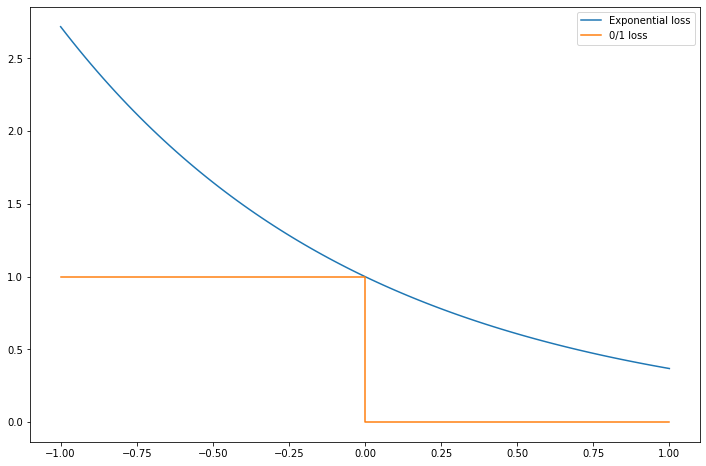

In [29]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(-1, 1, 101)
y = np.exp(-x)

plt.figure(figsize=(12, 8))
plt.plot(x, y, label='Exponential loss')
y = (x<=0).astype(int)
x[51] = 0
plt.plot(x, y, label='0/1 loss')
plt.legend()
plt.show()

On cherche à construire un classifieur $H$ minimisant la *loss* exponentielle suivante :

$$\mathcal{L}(H)=\sum_{i=1}^n\ell(y_iH(x_i)),$$

où 

$$H(x)=\frac{1}{2}\sum_j\alpha_j h_j(x),$$

tels que $h_j$ sont nos classifieurs faibles et $\alpha_j$ les poids qui leur sont associés. Cependant, imaginons qu'au lieu de tout minimiser d'une seule fois, nous procédions itérativement, classifieur par classifieur. Ainsi, lorsqu'on optimise le classifieur $j$, tous les classifieurs $h_{1}, \ldots, h_{j-1}$ et leur poid $\alpha_1, \ldots, \alpha_{j-1}$ restent fixés. Notons $H_m(x)$ le classifieur total jusqu'au classifieur faible $h_m$. Notre *loss* se reformule ainsi :

$$\mathcal{L}_j(H)=\sum_{i=1}^n\text{exp}\Big(-y_iH_{j-1}(x_i)-\frac{1}{2}y_i\alpha_jh_j(x_i)\Big)=\sum_{i=1}^nw_i^j\text{exp}\Big(-\frac{1}{2}y_i\alpha_jh_j(x_i)\Big),$$

où $w_i^j = \text{exp}(-y_iH_{j-1}(x_i))$. Notons que si nous sommes bien entrain d'optimiser notre loss du point de vue de $h_j$ et $\alpha_j$, alors $w_i^j, \forall i$ sont des constantes. Notons $S_c^{m}$ l'ensemble des points correctement classés par $H_m$ et $S_i^m$ ceux qui à l'inverse ne le sont pas. Nous pouvons reformuler l'erreur précédente de la manière suivante :

$$\begin{aligned}
\mathcal{L}_j(H)&=e^{-\alpha_j/2}\sum_{i\in S_\mathcal{c}^j}w_i^m+e^{\alpha_j/2}\sum_{i\in S_\mathcal{i}^j}w_i^m\\
&=(e^{\alpha_j/2}-e^{-\alpha_j/2})\sum_{i=1}^nw_i^m\textbf{1}\{h_j(x_i)\neq y_i\}+e^{-\alpha_j/2}\sum_{i=1}^nw_i^m\\
&\propto (e^{\alpha_j/2}-e^{-\alpha_j/2})\sum_{i=1}^nw_i^m\textbf{1}\{h_j(x_i)\neq y_i\}
\end{aligned}$$

Du point de vu de l'optimisation de $h_j$, on remarque que cela revient à optimiser :

$$(e^{\alpha_j/2}-e^{-\alpha_j/2})\sum_{i=1}^nw_i^m\textbf{1}\{h_j(x_i)\neq y_i\},$$

où le choix de $\alpha_j$ n'a pas d'effet. Cela revient à réaliser l'étape $2$ de notre algorithme. Considérons maintenant l'optimisation de $\alpha_j$. En annulant la derivée en fonction de $\alpha_j$ on se rend compte que cela revient à le calculer comme indiqué à l'étape 3 ($\epsilon_j$ et $\alpha_j$).

----

In [30]:
# exercice avec des stumps...

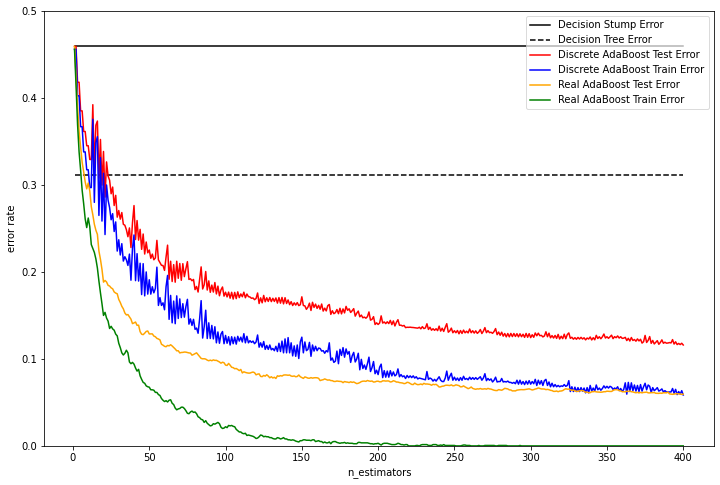

In [10]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import zero_one_loss
from sklearn.ensemble import AdaBoostClassifier


n_estimators = 400
# A learning rate of 1. may not be optimal for both SAMME and SAMME.R
learning_rate = 1.

X, y = datasets.make_hastie_10_2(n_samples=12000, random_state=1)

X_test, y_test = X[2000:], y[2000:]
X_train, y_train = X[:2000], y[:2000]

dt_stump = DecisionTreeClassifier(max_depth=1, min_samples_leaf=1)
dt_stump.fit(X_train, y_train)
dt_stump_err = 1.0 - dt_stump.score(X_test, y_test)

dt = DecisionTreeClassifier(max_depth=9, min_samples_leaf=1)
dt.fit(X_train, y_train)
dt_err = 1.0 - dt.score(X_test, y_test)

ada_discrete = AdaBoostClassifier(
    base_estimator=dt_stump,
    learning_rate=learning_rate,
    n_estimators=n_estimators,
    algorithm="SAMME")
ada_discrete.fit(X_train, y_train)

ada_real = AdaBoostClassifier(
    base_estimator=dt_stump,
    learning_rate=learning_rate,
    n_estimators=n_estimators,
    algorithm="SAMME.R")
ada_real.fit(X_train, y_train)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)

ax.plot([1, n_estimators], [dt_stump_err] * 2, 'k-',
        label='Decision Stump Error')
ax.plot([1, n_estimators], [dt_err] * 2, 'k--',
        label='Decision Tree Error')

ada_discrete_err = np.zeros((n_estimators,))
for i, y_pred in enumerate(ada_discrete.staged_predict(X_test)):
    ada_discrete_err[i] = zero_one_loss(y_pred, y_test)

ada_discrete_err_train = np.zeros((n_estimators,))
for i, y_pred in enumerate(ada_discrete.staged_predict(X_train)):
    ada_discrete_err_train[i] = zero_one_loss(y_pred, y_train)

ada_real_err = np.zeros((n_estimators,))
for i, y_pred in enumerate(ada_real.staged_predict(X_test)):
    ada_real_err[i] = zero_one_loss(y_pred, y_test)

ada_real_err_train = np.zeros((n_estimators,))
for i, y_pred in enumerate(ada_real.staged_predict(X_train)):
    ada_real_err_train[i] = zero_one_loss(y_pred, y_train)

ax.plot(np.arange(n_estimators) + 1, ada_discrete_err,
        label='Discrete AdaBoost Test Error',
        color='red')
ax.plot(np.arange(n_estimators) + 1, ada_discrete_err_train,
        label='Discrete AdaBoost Train Error',
        color='blue')
ax.plot(np.arange(n_estimators) + 1, ada_real_err,
        label='Real AdaBoost Test Error',
        color='orange')
ax.plot(np.arange(n_estimators) + 1, ada_real_err_train,
        label='Real AdaBoost Train Error',
        color='green')

ax.set_ylim((0.0, 0.5))
ax.set_xlabel('n_estimators')
ax.set_ylabel('error rate')

leg = ax.legend(loc='upper right', fancybox=True)
leg.get_frame().set_alpha(0.7)

plt.show()

## IV. Les forêts aléatoires

In [142]:
X_test.shape

(450, 64)